In [76]:
import os
import csv
import math
import itertools

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from scipy import sparse
import networkx as nx

from mbi import (
    Dataset,
    FactoredInference,
    Domain,
    LocalInference,
    MixtureInference,
    PublicInference,
)

import warnings
warnings.filterwarnings('ignore')

In [69]:
data = Dataset.load("data/adult_processed.csv", "data/adult_processed.json")

In [42]:
N = data.df.shape[0]
df = pd.DataFrame(columns=['col1','col2', 'score'])
idx = 0

In [43]:
# source: https://github.com/usnistgov/PrivacyEngCollabSpace/blob/master/tools/de-identification/Differential-Privacy-Synthetic-Data-Challenge-Algorithms/rmckenna/select-queries.ipynb

# calculate mutual info between every pair of attributes

for a,b in itertools.combinations(data.domain.attrs, 2):
    A = data.project(a).datavector() / N
    B = data.project(b).datavector() / N
    AB = data.project([a,b]).datavector() / N
    nz = AB > 0

    score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
    # print(a,b,score)
    df.loc[idx] = [a,b,score]
    df.loc[idx+1] = [b,a,score]
    idx += 2

df = df.sort_values('score')


/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_21158/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_21158/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_21158/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_21158/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_21158/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])


In [44]:
df.head()

,col1,col2,score
187,native.country,sex,0.002323
186,sex,native.country,0.002323
135,native.country,marital.status,0.002385
134,marital.status,native.country,0.002385
190,capital.gain,capital.loss,0.004159


In [45]:
nodes = data.domain.attrs
weights = df[df.col1.isin(nodes) & df.col2.isin(nodes)]
weights.head()

,col1,col2,score
187,native.country,sex,0.002323
186,sex,native.country,0.002323
135,native.country,marital.status,0.002385
134,marital.status,native.country,0.002385
190,capital.gain,capital.loss,0.004159


In [46]:
G = nx.Graph()
G.add_nodes_from(nodes)

for e1, e2, w in zip(weights['col1'], weights['col2'], weights['score']):
    G.add_edge(e1, e2, weight=w)

mst = nx.maximum_spanning_tree(G)

es = list(mst.edges)
print(es)
print(len(es))

[('age', 'fnlwgt'), ('workclass', 'fnlwgt'), ('fnlwgt', 'hours.per.week'), ('fnlwgt', 'occupation'), ('fnlwgt', 'education'), ('fnlwgt', 'relationship'), ('fnlwgt', 'sex'), ('fnlwgt', 'native.country'), ('fnlwgt', 'race'), ('fnlwgt', 'capital.gain'), ('fnlwgt', 'income'), ('fnlwgt', 'capital.loss'), ('education', 'education.num'), ('marital.status', 'relationship')]
14


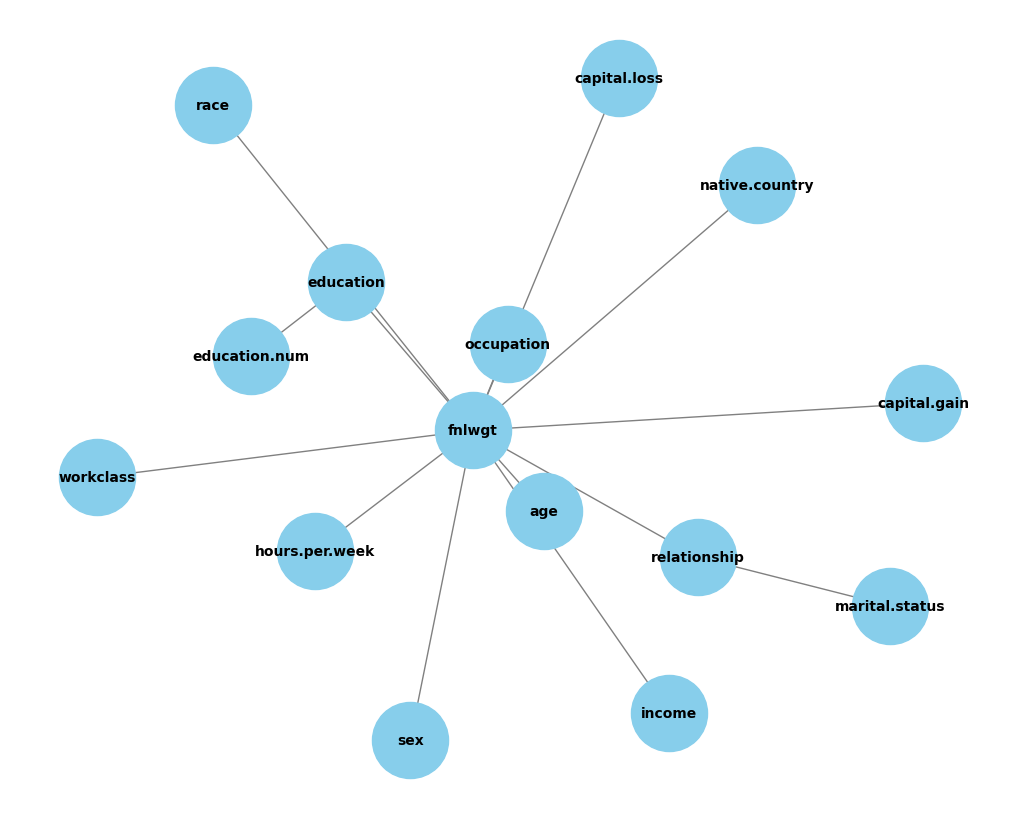

In [47]:
plt.figure(figsize=(10, 8))  # Set the figure size
pos = nx.spring_layout(G)  # Use spring layout for positioning nodes
nx.draw(mst, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=10, font_weight='bold', edge_color='gray')

# Show the plot
plt.show()

In [48]:
df = pd.DataFrame(columns=['col1','col2', 'score', 'bound'])
idx = 0

entropies = {key: -1 for key in data.domain.attrs}

for attr in data.domain.attrs:
    # Calculate probabilities
    probabilities = data.df[attr].value_counts(normalize=True)
    # Calculate Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))

    entropies[attr] = entropy

for a,b in itertools.combinations(data.domain.attrs, 2):
    A = data.project(a).datavector() / N
    B = data.project(b).datavector() / N
    AB = data.project([a,b]).datavector() / N
    nz = AB > 0

    score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
    df.loc[idx] = [a,b,score,min(entropies[a],entropies[b])]
    idx += 1

df = df.sort_values('score')

df = df[df['score'] > df['bound'] * 0.1]
df

/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_21158/2559294257.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_21158/2559294257.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_21158/2559294257.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_21158/2559294257.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_21158/2559294257.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])


,col1,col2,score,bound
10,age,capital.loss,0.053760,0.513923
98,capital.gain,income,0.083382,0.796384
9,age,capital.gain,0.090232,0.866149
63,marital.status,sex,0.094844,0.915736
88,race,native.country,0.098055,0.798741
71,occupation,sex,0.099309,0.915736
68,marital.status,income,0.101733,0.796384
83,relationship,income,0.114623,0.796384
78,relationship,sex,0.273147,0.915736
35,fnlwgt,capital.loss,0.304448,0.513923


In [49]:
tuple_list = list(zip(df['col1'], df['col2']))
es.extend(tuple_list)
es = list(set(es))
print(es)
print(len(es))

[('fnlwgt', 'race'), ('workclass', 'occupation'), ('workclass', 'fnlwgt'), ('fnlwgt', 'hours.per.week'), ('age', 'capital.gain'), ('fnlwgt', 'sex'), ('marital.status', 'income'), ('education', 'education.num'), ('race', 'native.country'), ('occupation', 'sex'), ('fnlwgt', 'education'), ('fnlwgt', 'occupation'), ('relationship', 'income'), ('fnlwgt', 'education.num'), ('fnlwgt', 'relationship'), ('marital.status', 'sex'), ('capital.gain', 'income'), ('fnlwgt', 'marital.status'), ('fnlwgt', 'capital.loss'), ('relationship', 'sex'), ('age', 'fnlwgt'), ('fnlwgt', 'native.country'), ('fnlwgt', 'capital.gain'), ('marital.status', 'relationship'), ('age', 'capital.loss'), ('fnlwgt', 'income')]
26


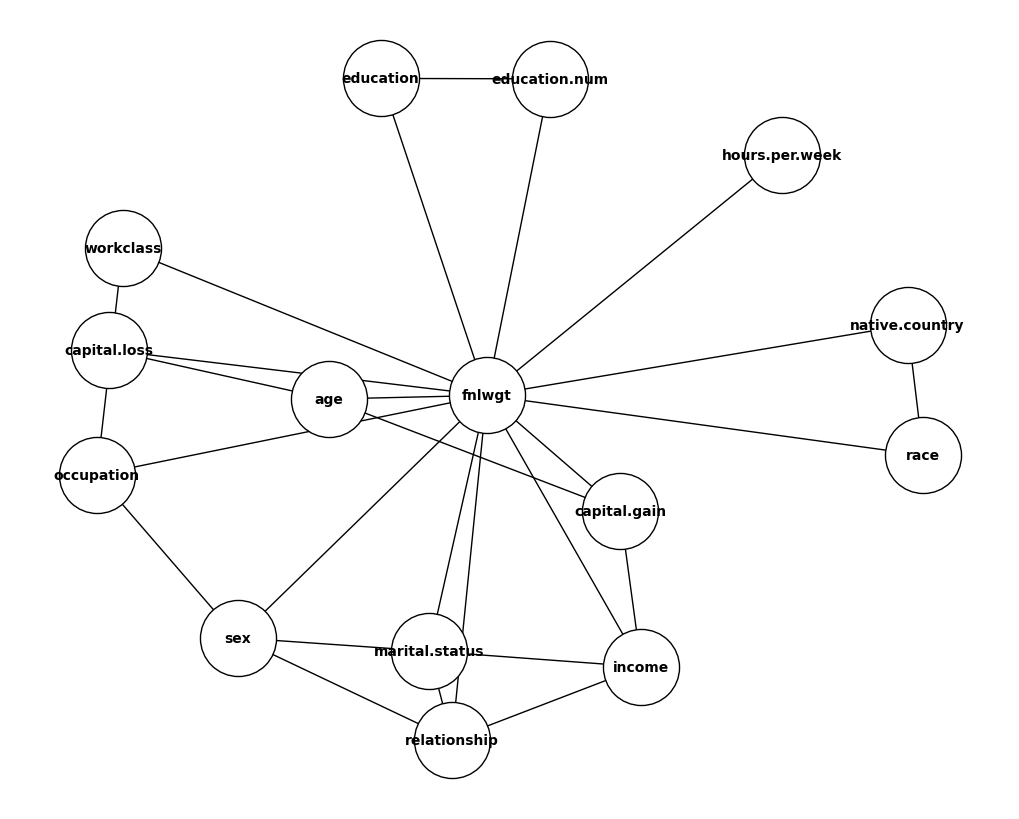

In [50]:
# Create a directed graph
G = nx.Graph()

# Add edges to the graph
G.add_edges_from(es)

plt.figure(figsize=(10, 8))  # Set the figure size
pos = nx.spring_layout(G)  # Use spring layout for positioning nodes
nx.draw(G, pos, with_labels=True, node_color='white', node_size=3000, font_size=10, font_weight='bold', edge_color='black', node_shape='o', edgecolors='black')

# Save the figure as a PDF
plt.savefig("../paper/images/adult_mst.pdf", format="pdf", bbox_inches='tight')  # Specify the format as PDF

# Show the plot
plt.show()

In [51]:
cliques = list(nx.find_cliques(G))
for c in cliques:
    print(c)

['fnlwgt', 'income', 'relationship', 'marital.status']
['fnlwgt', 'income', 'capital.gain']
['fnlwgt', 'workclass', 'occupation']
['fnlwgt', 'hours.per.week']
['fnlwgt', 'native.country', 'race']
['fnlwgt', 'occupation', 'sex']
['fnlwgt', 'education.num', 'education']
['fnlwgt', 'capital.loss', 'age']
['fnlwgt', 'age', 'capital.gain']
['fnlwgt', 'sex', 'relationship', 'marital.status']


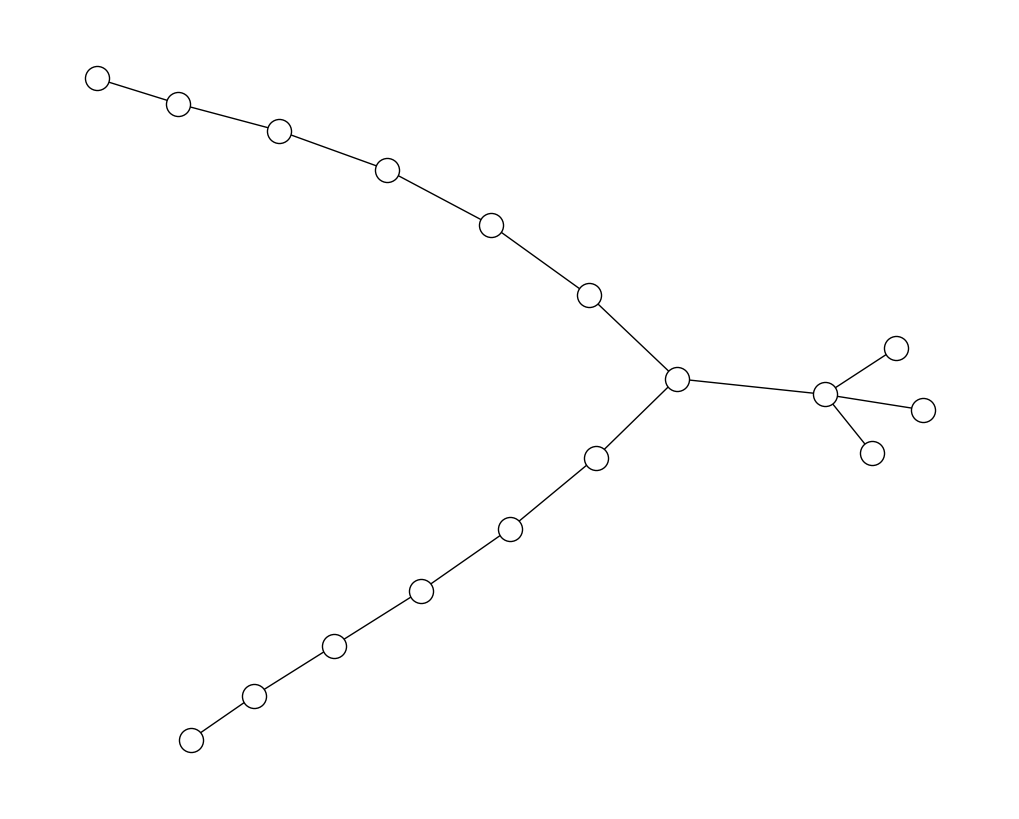

In [52]:
G = nx.junction_tree(G)
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=False, node_color='white', node_size=300, font_size=0, edge_color='black', node_shape='o', edgecolors='black')
plt.savefig("../paper/images/adult_junction.pdf", format="pdf", bbox_inches='tight')
plt.show()

# the "sophisticated heuristic" mentioned in paper

In [98]:
N = data.df.shape[0]
df = pd.DataFrame(columns=['col1','col2', 'score'])
idx = 0

for a,b in itertools.combinations(data.domain.attrs, 2):
    A = data.project(a).datavector() / N
    B = data.project(b).datavector() / N
    AB = data.project([a,b]).datavector() / N
    nz = AB > 0

    score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
    # print(a,b,score)
    df.loc[idx] = [a,b,score]
    df.loc[idx+1] = [b,a,score]
    idx += 2

df = df.sort_values('score')

nodes = data.domain.attrs
weights = df[df.col1.isin(nodes) & df.col2.isin(nodes)]

G = nx.Graph()
G.add_nodes_from(nodes)

for e1, e2, w in zip(weights['col1'], weights['col2'], weights['score']):
    G.add_edge(e1, e2, weight=w)

mst = nx.maximum_spanning_tree(G)

In [78]:
G = nx.Graph()
G.add_nodes_from(nodes)

for e1, e2, w in zip(weights['col1'], weights['col2'], weights['score']):
    G.add_edge(e1, e2, weight=w)

mst = nx.maximum_spanning_tree(G)
print(list(mst.edges))
print(len(es))

res = pd.DataFrame(columns=['A','B','C','size','score'])
i = 0
N = data.df.shape[0]

for A in nodes:
    for B, C in itertools.combinations(mst.neighbors(A), 2):
        AB = data.df.groupby([A,B]).size().unstack().fillna(0).values / N
        AC = data.df.groupby([A,C]).size().unstack().fillna(0).values / N
        a,b = AB.shape
        a,c = AC.shape
        AB, AC = AB.reshape(a,b,1), AC.reshape(a,1,c)

        ABC2 = AB * AC / AB.sum(axis=1, keepdims=True)

        ABC = data.df.groupby([A,B,C]).size().unstack().fillna(0).unstack().fillna(0).stack().stack().values.reshape(a,b,c) / N

        score = np.abs(ABC - ABC2).sum()
        #AB = data.project([A,B]).datavector()
        #AC = data.project([A,C]).datavector()
        print(A,B,C)
        res.loc[i] = [A,B,C,a*b*c,score]
        i = i + 1

#res[res.score >= 0.05].sort_values('size',ascending=True)

print([tuple(row) for row in res.loc[res.score >= 0.10,['A','B','C']].values])

ans = []
for col in nodes:
    lookup = res.loc[res.A == col]
    G = nx.Graph()
    G.add_nodes_from(mst.neighbors(col))

    for e1, e2, w in zip(lookup['B'], lookup['C'], lookup['score']):
        if w >= 0.1:
            G.add_edge(e1, e2, weight=w)

    tree = nx.maximum_spanning_tree(G)
    ans += list(tree.edges)
    ans += [(col,) + e for e in tree.edges]
print(ans)

[('age', 'fnlwgt'), ('workclass', 'fnlwgt'), ('fnlwgt', 'hours.per.week'), ('fnlwgt', 'occupation'), ('fnlwgt', 'education'), ('fnlwgt', 'relationship'), ('fnlwgt', 'sex'), ('fnlwgt', 'native.country'), ('fnlwgt', 'race'), ('fnlwgt', 'capital.gain'), ('fnlwgt', 'income'), ('fnlwgt', 'capital.loss'), ('education', 'education.num'), ('marital.status', 'relationship')]
14
fnlwgt age hours.per.week
fnlwgt age occupation
fnlwgt age education
fnlwgt age relationship
fnlwgt age workclass
fnlwgt age sex
fnlwgt age native.country
fnlwgt age race
fnlwgt age capital.gain
fnlwgt age income
fnlwgt age capital.loss
fnlwgt hours.per.week occupation
fnlwgt hours.per.week education
fnlwgt hours.per.week relationship
fnlwgt hours.per.week workclass
fnlwgt hours.per.week sex
fnlwgt hours.per.week native.country
fnlwgt hours.per.week race
fnlwgt hours.per.week capital.gain
fnlwgt hours.per.week income
fnlwgt hours.per.week capital.loss
fnlwgt occupation education
fnlwgt occupation relationship
fnlwgt occu

In [83]:
ans

[('age', 'occupation'),
 ('hours.per.week', 'occupation'),
 ('occupation', 'education'),
 ('occupation', 'relationship'),
 ('occupation', 'workclass'),
 ('occupation', 'income'),
 ('fnlwgt', 'age', 'occupation'),
 ('fnlwgt', 'hours.per.week', 'occupation'),
 ('fnlwgt', 'occupation', 'education'),
 ('fnlwgt', 'occupation', 'relationship'),
 ('fnlwgt', 'occupation', 'workclass'),
 ('fnlwgt', 'occupation', 'income')]

<Figure size 1000x800 with 0 Axes>

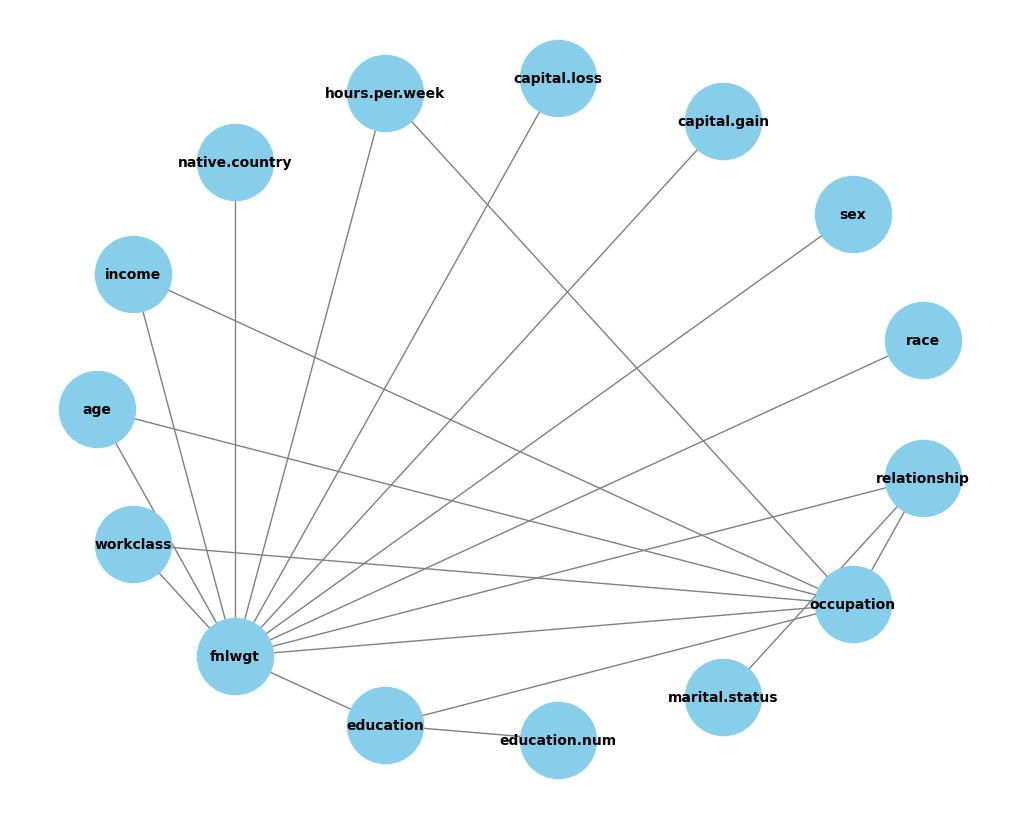

In [97]:
G = mst

for clique in ans:
    for i in range(len(clique)):
        for j in range(i + 1, len(clique)):
            G.add_edge(clique[i], clique[j])

plt.figure(figsize=(10, 8))  # Set the figure size
pos = nx.shell_layout(G)  # Use spring layout for positioning nodes
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=10, font_weight='bold', edge_color='gray')

# Show the plot
plt.show()